In [2]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

In [3]:
%matplotlib inline
%load_ext google.cloud.bigquery

In [19]:
%%bigquery
select count(*) as total_count from `bigquery-samples.airline_ontime_data.flights`

,total_count
0,70588485


First, let's concentrate on the larger airports, i.e. those with more than a hundred flights per day in average. We create a temporary table that will cease to exist 24 hours from now to hold airports by capacity.

In [22]:
%%bigquery
create or replace table examples.temp_airports_capacity 
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 1 DAY)
) as (
with d_gbdaa as (
    SELECT departure_airport as airport, date, count(*) as num_out
      FROM `bigquery-samples.airline_ontime_data.flights` group by airport, date),
a_gbdaa as (
    SELECT arrival_airport as airport, date, count(*) as num_in
      FROM `bigquery-samples.airline_ontime_data.flights` group by airport, date
),
combined as (
    select d_gbdaa.airport, num_in + num_out as capacity
        from d_gbdaa join a_gbdaa on
        a_gbdaa.airport = d_gbdaa.airport
        and a_gbdaa.date = d_gbdaa.date
),
averages as (select airport, avg(capacity) as avg_capa from combined 
group by airport)

select airport, avg_capa from averages order by avg_capa desc
)


""


We now quantize over the hour of a particular day to understand intra-day behaviour. We use the bigquery extension to design the statement.

In [84]:
%%bigquery sample_a_day
select 
  c.airport,
  f.date,
  floor(f.departure_schedule / 100) as hour,
  count(*) as num_flights,
  approx_quantiles(f.departure_delay, 10)[ordinal(1)] as min_delay,
  approx_quantiles(f.departure_delay, 10)[ordinal(2)] as q1,
  approx_quantiles(f.departure_delay, 10)[ordinal(3)] as q2,
  approx_quantiles(f.departure_delay, 10)[ordinal(4)] as q3,
  approx_quantiles(f.departure_delay, 10)[ordinal(5)] as q4,
  approx_quantiles(f.departure_delay, 10)[ordinal(6)] as q5,
  approx_quantiles(f.departure_delay, 10)[ordinal(7)] as q6,
  approx_quantiles(f.departure_delay, 10)[ordinal(8)] as q7,
  approx_quantiles(f.departure_delay, 10)[ordinal(9)] as q8,
  approx_quantiles(f.departure_delay, 10)[ordinal(10)] as q9,
  max(f.departure_delay) as max_delay, 
  avg(f.departure_delay) as avg_delay
from 
  `bigquery-samples.airline_ontime_data.flights`  f
join
  `examples.temp_airports_capacity` c
on 
  f.departure_airport = c.airport 
where c.avg_capa > 1000 and
  f.date = '2008-01-01'
group by airport, date, hour
order by airport, date, hour
limit 3

,airport,date,hour,num_flights,min_delay,q1,q2,q3,q4,q5,q6,q7,q8,q9,max_delay,avg_delay
0,ATL,2008-01-01,6.0,7,-4.0,-4.0,-2.0,-1.0,-1.0,2.0,3.0,3.0,5.0,32.0,32.0,5.000000
1,ATL,2008-01-01,7.0,17,-11.0,-5.0,-5.0,-4.0,-4.0,-3.0,-2.0,-2.0,-1.0,0.0,9.0,-2.529412
2,ATL,2008-01-01,8.0,56,-14.0,-6.0,-4.0,-3.0,-2.0,-1.0,0.0,0.0,2.0,7.0,47.0,0.196429


...and datalab bigquery library to execute the statement. That keeps the notebook cleaner. We pay a little price by duplicating the above statement, though...;-(

In [124]:
STATEMENT="""
select 
  c.airport,
  f.date,
  floor(f.departure_schedule / 100) as hour,
  count(*) as num_flights,
  approx_quantiles(f.departure_delay, 10)[ordinal(1)] as min_delay,
  approx_quantiles(f.departure_delay, 10)[ordinal(2)] as q1,
  approx_quantiles(f.departure_delay, 10)[ordinal(3)] as q2,
  approx_quantiles(f.departure_delay, 10)[ordinal(4)] as q3,
  approx_quantiles(f.departure_delay, 10)[ordinal(5)] as q4,
  approx_quantiles(f.departure_delay, 10)[ordinal(6)] as q5,
  approx_quantiles(f.departure_delay, 10)[ordinal(7)] as q6,
  approx_quantiles(f.departure_delay, 10)[ordinal(8)] as q7,
  approx_quantiles(f.departure_delay, 10)[ordinal(9)] as q8,
  approx_quantiles(f.departure_delay, 10)[ordinal(10)] as q9,
  max(f.departure_delay) as max_delay, 
  avg(f.departure_delay) as avg_delay
from 
  `bigquery-samples.airline_ontime_data.flights`  f
join
  `examples.temp_airports_capacity` c
on 
  f.departure_airport = c.airport 
where c.avg_capa > 1000 and
  f.date = '2008-01-01'
group by airport, date, hour
order by airport, date, hour
"""
import google.datalab.bigquery as dlbq
sample_a_day=dlbq.Query(STATEMENT).execute().result().to_dataframe()

In [125]:
sample_a_day.airport.unique()

array(['ATL', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX'], dtype=object)

In [70]:
import seaborn as sns
import pandas as pd

In [71]:
sample_a_day.head()

,airport,date,hour,num_flights,min_delay,q1,q2,q3,q4,q5,q6,q7,q8,q9,max_delay,avg_delay
0,ATL,2008-01-01,6.0,7,-4.0,-4.0,-2.0,-1.0,-1.0,2.0,3.0,3.0,5.0,32.0,32.0,5.000000
1,ATL,2008-01-01,7.0,17,-11.0,-5.0,-5.0,-4.0,-4.0,-3.0,-2.0,-2.0,-1.0,0.0,9.0,-2.529412
2,ATL,2008-01-01,8.0,56,-14.0,-6.0,-4.0,-3.0,-2.0,-1.0,0.0,0.0,2.0,7.0,47.0,0.196429
3,ATL,2008-01-01,9.0,70,-9.0,-3.0,-2.0,-1.0,-1.0,0.0,3.0,8.0,14.0,22.0,52.0,6.014286
4,ATL,2008-01-01,10.0,60,-8.0,-5.0,-3.0,-3.0,-2.0,-1.0,0.0,3.0,8.0,17.0,136.0,5.850000


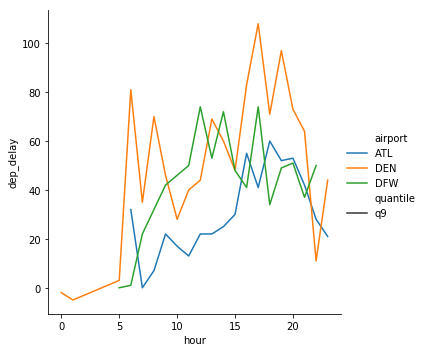

In [83]:
data=sample_a_day[sample_a_day['airport'].isin(['ATL', 'DEN', 'DFW'])]
data=data[['hour', 'airport', 'q9']]
data=pd.melt(data, id_vars=['hour', 'airport'], var_name='quantile', value_name='dep_delay')
data.head()
sns.relplot(x='hour', y='dep_delay', data=data, 
            style='quantile', hue='airport', kind='line');

I'm starting to believe that the 9<sup>th</sup> decile is preferrable to the mean, since the mean is too much dependent on those extreme delay outliers that won't be easy to predict, anyway. So, let's study the maximum over each day of the 9<sup>th</sup> decile throughout the year to understand whether holidays do contribute to departure delays.

In [113]:
%%bigquery sample_a_year
with by_the_hour as (
    select 
      departure_airport,
      extract(dayofyear from parse_date( "%Y-%m-%d", date)) as day_of_year,
      date,
      floor(f.departure_schedule / 100) as hour,
      approx_quantiles(f.departure_delay, 10)[ordinal(10)] as q9
    from 
      `bigquery-samples.airline_ontime_data.flights`  f
    where 
        f.departure_airport='ATL'
    group by departure_airport, date, hour
    order by departure_airport, date, hour
)
select 
    departure_airport,
    date,
    day_of_year,
    avg(q9) as avgq9
from
    by_the_hour
--where
--    extract(year from parse_date( "%Y-%m-%d", date)) = 2008
group by 
    departure_airport, date, day_of_year
order by 
    departure_airport, day_of_year
limit 3

,departure_airport,date,day_of_year,avgq9
0,ATL,2005-01-01,1,14.055556
1,ATL,2006-01-01,1,64.611111
2,ATL,2002-01-01,1,14.111111


In [132]:
STATEMENT="""
with by_the_hour as (
    select 
      departure_airport,
      extract(dayofyear from parse_date( "%Y-%m-%d", date)) as day_of_year,
      date,
      floor(f.departure_schedule / 100) as hour,
      approx_quantiles(f.departure_delay, 10)[ordinal(10)] as q9
    from 
      `bigquery-samples.airline_ontime_data.flights`  f
    where 
        f.departure_airport='ATL'
    group by departure_airport, date, hour
    order by departure_airport, date, hour
)
select 
    departure_airport,
    date,
    day_of_year,
    avg(q9) as avgq9
from
    by_the_hour
--where
--    extract(year from parse_date( "%Y-%m-%d", date)) = 2008
group by 
    departure_airport, date, day_of_year
order by 
    departure_airport, day_of_year"""
sample_a_year=dlbq.Query(STATEMENT).execute().result().to_dataframe()

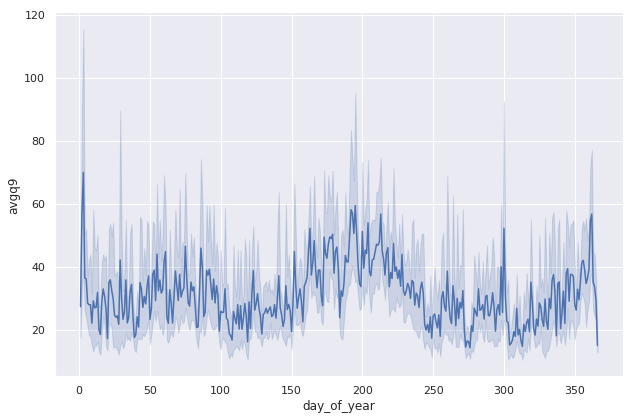

In [133]:
sns.relplot(data=sample_a_year, x='day_of_year', y='avgq9', 
            kind='line',height=6, aspect=1.5);

In [118]:
sample_a_year[sample_a_year['avgq9']>200]

,departure_airport,date,day_of_year,avgq9
29,ATL,2002-01-03,3,272.500000
312,ATL,2005-01-29,29,269.062500
2137,ATL,2008-07-13,195,222.111111
